# Introduction

## Business Problem
Financial institutions need a reliable way to classify customer credit scores (Poor, Standard, Good) to reduce default risk, streamline approvals, and calibrate lending limits. This notebook builds the exploratory analysis and preprocessing pipeline that feeds the production-ready models.

## Key Findings
- **Dataset:** 28K+ customers with 29 banking and demographic features (payment behaviour, utilization, loan mix, etc.)
- **Data Quality:** Corrupted numeric strings (underscores) cleaned, missing data imputed, and extreme outliers removed via an IQR strategy
- **Class Distribution:** Mild imbalance across Poor/Standard/Good, motivating stratified splits and per-class metrics
- **Model Performance Preview:** Tuned Random Forest reaches ~0.79 accuracy with balanced precision/recall across classes

## Methodology
1. **Data Cleaning** – remove corrupted tokens, impute missing categorical/numeric values
2. **Feature Engineering** – ordinal encoding for ordered categories, one-hot encoding for nominal features
3. **Outlier Treatment** – IQR-based removal to stabilize training for variance-sensitive models
4. **Model Comparison** – Decision Tree, Random Forest, and KNN evaluated with GridSearchCV + bootstrap stress tests
5. **Reporting** – Confusion matrices and false-positive analysis from a lending-risk perspective

## Business Impact
- **Risk Assessment:** Better classification supports conservative credit limit adjustments
- **Operational Efficiency:** Automated scoring shortens manual underwriting cycles
- **Portfolio Monitoring:** Early warnings for high-risk accounts enable proactive outreach

## Recommendations
- Use the tuned Random Forest as the baseline production model
- Track feature importance quarterly and retrain with the most recent data
- Explore cost-sensitive training to penalize high-risk false positives
- Extend with ensemble or calibration methods when new performance targets emerge

---

In [1]:
# Environment setup and reproducibility
# Why: Explicit version logging improves reproducibility and helps diagnose
# discrepancies if results differ on another machine or future reruns.
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

print("=== Environment Information ===")
print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

# Single source of randomness: ensures consistent CV splits & any stochastic model behavior.
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print(f"\nRandom seed set to: {RANDOM_STATE}")

=== Environment Information ===
Python: 3.12.5
Pandas: 2.2.3
NumPy: 2.1.3
Scikit-learn: 1.6.1
Matplotlib: 3.10.1
Seaborn: 0.13.2

Random seed set to: 42


# Credit Score Classification - EDA & Preprocessing

**Objective:** Build a robust classification pipeline to predict customer credit scores (Poor, Standard, Good) using banking and demographic data.

**Key Steps:**
- Data loading and initial exploration
- Cleaning corrupted values and handling missing data
- Outlier detection and removal using IQR method
- Feature engineering: ordinal encoding, one-hot encoding
- Train/test split with standardization
- Model comparison: Decision Tree, Random Forest, KNN
- Performance evaluation with confusion matrices and error analysis

**Dataset:** Credit score data with 29+ features including payment history, credit utilization, demographics, and loan information.

# Load Data
The raw dataset resides under `../data/raw/set_credit_score.csv`, keeping the repository fully portable. All subsequent save operations target `../data/processed/` so downstream notebooks can reuse the cleaned artifacts.

In [2]:
# Load credit score dataset from project data folder
df = pd.read_csv('../data/raw/set_credit_score.csv')
df.head()

C:\Users\Vespula\AppData\Local\Temp\ipykernel_22376\565643652.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/set_credit_score.csv')


,Unnamed: 0,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529544,High_spent_Small_value_payments,312.4940887,Good
1,1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,...,Good,809.98,31.944960,NaN,No,49.574949,118.2802216,Low_spent_Large_value_payments,284.6291625,Good
2,2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.69952126,Low_spent_Medium_value_payments,331.2098629,Good
3,3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580744,Low_spent_Small_value_payments,223.4513097,Good
4,4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.42015309,High_spent_Medium_value_payments,341.489231,Good


## Target Variable Analysis: Class Imbalance

Understanding the distribution of our target variable is critical for model selection and evaluation. Class imbalance can lead to biased predictions toward the majority class.

# EDA
This section explores target balance, feature distributions, and categorical relationships prior to any heavy preprocessing steps.

=== Credit Score Distribution ===
Credit_Score
Good        17828
Poor        28998
Standard    53174
Name: count, dtype: int64

Class Proportions:
Credit_Score
Good        0.17828
Poor        0.28998
Standard    0.53174
Name: proportion, dtype: float64


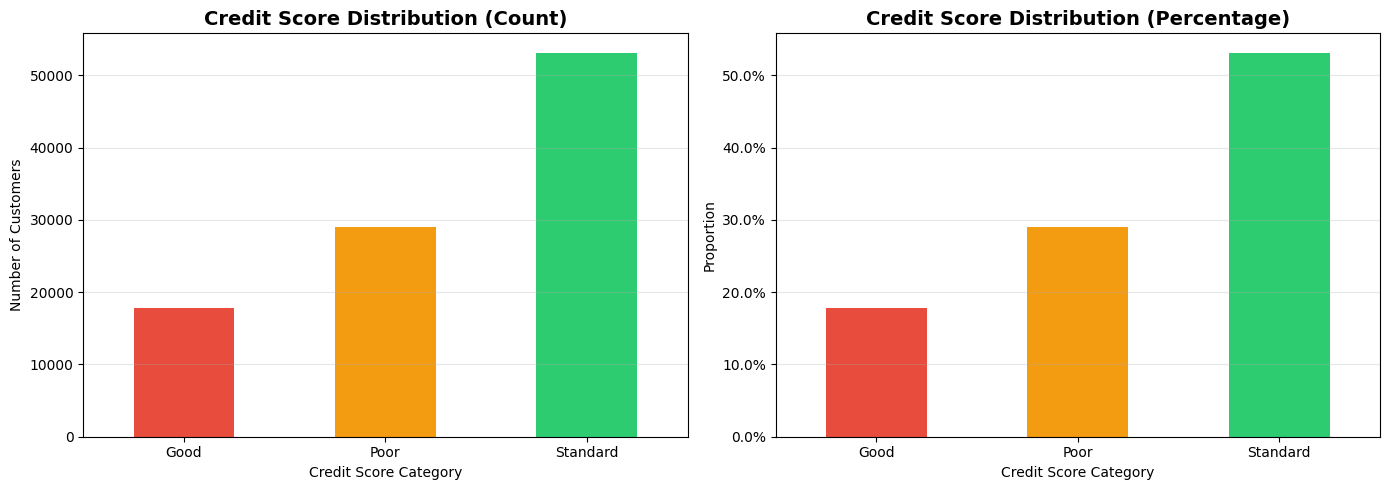


=== Class Imbalance Ratios ===
Good: 1:2.98 (relative to majority class)
Poor: 1:1.83 (relative to majority class)
Standard: 1:1.00 (relative to majority class)

⚠️ NOTICE: Moderate class imbalance detected (max ratio: 1:2.98)
Recommendation: Use stratified sampling and monitor per-class metrics


In [3]:
# Analyze target variable distribution
print("=== Credit Score Distribution ===")
print(df['Credit_Score'].value_counts().sort_index())
print("\nClass Proportions:")
print(df['Credit_Score'].value_counts(normalize=True).sort_index())

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['Credit_Score'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[0].set_title('Credit Score Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Credit Score Category')
axes[0].set_ylabel('Number of Customers')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Percentage plot
df['Credit_Score'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[1], color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[1].set_title('Credit Score Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Credit Score Category')
axes[1].set_ylabel('Proportion')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Imbalance ratio analysis
counts = df['Credit_Score'].value_counts().sort_index()
max_class = counts.max()
print("\n=== Class Imbalance Ratios ===")
for category in counts.index:
    ratio = max_class / counts[category]
    print(f"{category}: 1:{ratio:.2f} (relative to majority class)")
    
# Recommendation based on imbalance
max_ratio = max_class / counts.min()
if max_ratio > 3:
    print(f"\n⚠️ WARNING: Severe class imbalance detected (max ratio: 1:{max_ratio:.2f})")
    print("Recommendation: Consider using:")
    print("  - SMOTE (Synthetic Minority Over-sampling)")
    print("  - Class weights in models")
    print("  - Stratified sampling in train/test split")
elif max_ratio > 1.5:
    print(f"\n⚠️ NOTICE: Moderate class imbalance detected (max ratio: 1:{max_ratio:.2f})")
    print("Recommendation: Use stratified sampling and monitor per-class metrics")
else:
    print(f"\n✓ Classes are relatively balanced (max ratio: 1:{max_ratio:.2f})")

## Drop Unnecessary Columns

Remove identifier columns and features that don't contribute to prediction (PII and duplicate IDs).

# Preprocessing & Feature Engineering
This block covers column pruning, corruption fixes, missing-value handling, outlier treatment, encoding, and feature scaling to create the modeling-ready dataset.

In [4]:
# Drop personally identifiable or leak-prone columns.
# Why: IDs, names, and SSN do not carry predictive signal for credit score,
# risk privacy exposure, and may introduce data leakage if linked externally.
df_cleaned = df.drop(columns=['Unnamed: 0', 'ID', 'Customer_ID', 'Name', 'SSN'], errors='ignore')
df_cleaned.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,January,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529544,High_spent_Small_value_payments,312.4940887,Good
1,February,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,31.944960,NaN,No,49.574949,118.2802216,Low_spent_Large_value_payments,284.6291625,Good
2,March,-500,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.69952126,Low_spent_Medium_value_payments,331.2098629,Good
3,April,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580744,Low_spent_Small_value_payments,223.4513097,Good
4,May,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.42015309,High_spent_Medium_value_payments,341.489231,Good


In [5]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Monthly_Inhand_Salary     84998 non-null   float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  object 
 9   Type_of_Loan              88592 non-null   object 
 10  Delay_from_due_date       100000 non-null  int64  
 11  Num_of_Delayed_Payment    92998 non-null   object 
 12  Changed_Credit_Limit      100000 non-null  object 
 13  Num_Credit_Inquiries      98035 non-null   fl

In [6]:
# Display categorical columns and their unique values
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

for col in categorical_cols:
	print(f"Column: {col}")
	print(df_cleaned[col].unique())
	print("-" * 40)

Column: Month
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']
----------------------------------------
Column: Age
['23' '-500' '28_' ... '4808_' '2263' '1342']
----------------------------------------
Column: Occupation
['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']
----------------------------------------
Column: Annual_Income
['19114.12' '34847.84' '34847.84_' ... '20002.88' '39628.99' '39628.99_']
----------------------------------------
Column: Num_of_Loan
['4' '1' '3' '967' '-100' '0' '0_' '2' '3_' '2_' '7' '5' '5_' '6' '8' '8_'
 '9' '9_' '4_' '7_' '1_' '1464' '6_' '622' '352' '472' '1017' '945' '146'
 '563' '341' '444' '720' '1485' '49' '737' '1106' '466' '728' '313' '843'
 '597_' '617' '119' '663' '640' '92_' '1019' '501' '1302' '39' '716' '848'
 '931' '1214' '186' '424' '1001' '1110' '1152' '457' '1433' '1187' '52'
 '14

In [7]:
# Inspect numeric columns for corrupted values (containing underscore '_')
numeric_cols_to_check = ['Monthly_Balance', 'Amount_invested_monthly', 'Changed_Credit_Limit', 
                         'Outstanding_Debt', 'Num_of_Delayed_Payment', 'Annual_Income', 'Age', 'Num_of_Loan']

for col in numeric_cols_to_check:
    print(f"Column: {col}")
    print("Unique values:", df_cleaned[col].nunique())
    print("Values with '_':", df_cleaned[col].astype(str).str.contains('_').sum())
    print("First unique values:", df_cleaned[col].unique()[:10])
    print("-" * 40)

Column: Monthly_Balance
Unique values: 98790
Values with '_': 9
First unique values: ['312.4940887' '284.6291625' '331.2098629' '223.4513097' '341.489231'
 '340.4792118' '244.5653167' '358.1241676' '470.6906269' '484.5912143']
----------------------------------------
Column: Amount_invested_monthly
Unique values: 91049
Values with '_': 4305
First unique values: ['80.41529544' '118.2802216' '81.69952126' '199.4580744' '41.42015309'
 '62.43017233' '178.3440674' '24.78521651' '104.2918252' '40.39123783']
----------------------------------------
Column: Changed_Credit_Limit
Unique values: 98790
Values with '_': 9
First unique values: ['312.4940887' '284.6291625' '331.2098629' '223.4513097' '341.489231'
 '340.4792118' '244.5653167' '358.1241676' '470.6906269' '484.5912143']
----------------------------------------
Column: Amount_invested_monthly
Unique values: 91049
Values with '_': 4305
First unique values: ['80.41529544' '118.2802216' '81.69952126' '199.4580744' '41.42015309'
 '62.4301723

In [8]:
# Clean corrupted numeric values by removing '_' character.
# Why: Presence of '_' indicates ingestion/parsing issues (string artifacts).
# Converting to numeric with coercion standardizes invalid tokens to NaN for principled imputation.
df_numeric_fixed = df_cleaned.copy()

for col in numeric_cols_to_check:
    df_numeric_fixed[col] = df_cleaned[col].astype(str).str.replace('_', '', regex=False)
    df_numeric_fixed[col] = pd.to_numeric(df_numeric_fixed[col], errors='coerce')

# Verify correction integrity
for col in numeric_cols_to_check:
    print(f"Column: {col}")
    print("Unique values:", df_numeric_fixed[col].nunique())
    print("Values with '_':", df_numeric_fixed[col].astype(str).str.contains('_').sum())
    print("First unique values:", df_numeric_fixed[col].unique()[:10])
    print("-" * 40)

Column: Monthly_Balance
Unique values: 98790
Values with '_': 0
First unique values: [312.4940887 284.6291625 331.2098629 223.4513097 341.489231  340.4792118
 244.5653167 358.1241676 470.6906269 484.5912143]
----------------------------------------
Column: Amount_invested_monthly
Unique values: 91049
Values with '_': 0
First unique values: [ 80.41529544 118.2802216   81.69952126 199.4580744   41.42015309
  62.43017233 178.3440674   24.78521651 104.2918252   40.39123783]
----------------------------------------
Column: Changed_Credit_Limit
Unique values: 3634
Values with '_': 0
First unique values: [11.27   nan  6.27  9.27  5.42  7.42  6.42  7.1  11.1   9.1 ]
----------------------------------------
Column: Outstanding_Debt
Unique values: 12203
Values with '_': 0
First unique values: [ 80.41529544 118.2802216   81.69952126 199.4580744   41.42015309
  62.43017233 178.3440674   24.78521651 104.2918252   40.39123783]
----------------------------------------
Column: Changed_Credit_Limit
Uni

In [9]:
df_numeric_fixed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     100000 non-null  object 
 1   Age                       100000 non-null  int64  
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  float64
 4   Monthly_Inhand_Salary     84998 non-null   float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  int64  
 9   Type_of_Loan              88592 non-null   object 
 10  Delay_from_due_date       100000 non-null  int64  
 11  Num_of_Delayed_Payment    92998 non-null   float64
 12  Changed_Credit_Limit      97909 non-null   float64
 13  Num_Credit_Inquiries      98035 non-null   fl

## Handle Missing Values

Strategy: Categorical variables → mode (most frequent), Numeric variables → median (robust to outliers).

In [10]:
# Missing value strategy: mode for categorical (preserves most common label),
# median for numeric (robust to outliers vs mean). This minimizes distortion of
# skewed financial distributions while retaining categorical frequency structure.
categorical_cols = df_numeric_fixed.select_dtypes(include=['object']).columns
numeric_cols = df_numeric_fixed.select_dtypes(include=[np.number]).columns

for col in df_numeric_fixed.columns:
    if df_numeric_fixed[col].isnull().sum() > 0:
        if col in categorical_cols:
            df_numeric_fixed[col] = df_numeric_fixed[col].fillna(df_numeric_fixed[col].mode()[0])
        elif col in numeric_cols:
            df_numeric_fixed[col] = df_numeric_fixed[col].fillna(df_numeric_fixed[col].median())

print("Missing values per column:")
print(df_numeric_fixed.isnull().sum())

Missing values per column:
Month                       0
Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64


In [11]:
# IQR-based outlier removal.
# Why: Extreme financial values (e.g., debt spikes) can overly influence models,
# especially distance-based or variance-sensitive algorithms. Removing gross outliers
# improves generalization. Caveat: may discard rare but informative risk cases—
# track removal percentage for transparency.

def remove_outliers_iqr(df, num_cols):
    df_clean = df.copy()
    for col in num_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

df_no_outliers = remove_outliers_iqr(df_numeric_fixed, numeric_cols)
print(f"Original shape: {df_numeric_fixed.shape}")
print(f"Shape after outlier removal: {df_no_outliers.shape}")
print(f"Rows removed: {df_numeric_fixed.shape[0] - df_no_outliers.shape[0]} ({100 * (df_numeric_fixed.shape[0] - df_no_outliers.shape[0]) / df_numeric_fixed.shape[0]:.1f}%)")

Original shape: (100000, 24)
Shape after outlier removal: (56312, 24)
Rows removed: 43688 (43.7%)


In [12]:
# Inspect Month variable distribution
print("Month value counts:")
print(df_no_outliers['Month'].value_counts())
print("\nUnique months:")
print(df_no_outliers['Month'].unique())

Month value counts:
Month
February    7144
January     7084
March       7072
May         7032
June        7026
April       7024
July        6996
August      6934
Name: count, dtype: int64

Unique months:
['January' 'February' 'April' 'May' 'June' 'July' 'August' 'March']


In [13]:
print("Duplicate rows:", df_no_outliers.duplicated().sum())

Duplicate rows: 0


## Observation: Month Variable

Analysis of the `Month` variable shows uniform distribution across all months, which is uncommon in real-world data and suggests synthetic or artificially balanced data.

**Implication:**  
Due to lack of variability, the `Month` variable likely won't contribute meaningful predictive information since it doesn't discriminate between classes or reflect real temporal patterns. Consider excluding it from modeling or assigning low feature importance.

In [14]:
# Display unique values for each categorical column
for col in categorical_cols:
    print(f"Column: {col}")
    print(df_no_outliers[col].unique())
    print("-" * 40)

Column: Month
['January' 'February' 'April' 'May' 'June' 'July' 'August' 'March']
----------------------------------------
Column: Occupation
['Scientist' '_______' 'Teacher' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Journalist' 'Engineer' 'Manager' 'Musician' 'Mechanic'
 'Writer' 'Accountant' 'Architect' 'Doctor']
----------------------------------------
Column: Type_of_Loan
['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'
 'Credit-Builder Loan' 'Not Specified' ...
 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan'
 'Payday Loan, Student Loan, Mortgage Loan, and Not Specified'
 'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan']
----------------------------------------
Column: Credit_Mix
['_' 'Good' 'Standard' 'Bad']
----------------------------------------
Column: Credit_History_Age
['22 Years and 1 Months' '15 Years and 11 Months' '22 Years and 4 Months'
 '22 Years and 5 Months' '22 Years and 6 Months' '22 Years and 7 Mo

## Clean Categorical Variables

### Summary of Categorical Data Cleaning

During exploratory analysis, corrupted or non-informative values were detected in several categorical columns:

- **Occupation:** Found value `'_______'`, representing missing or unreported data.
- **Credit_Mix:** Detected value `'_'`, which doesn't correspond to any valid category.
- **Payment_Behaviour:** Found value `'!@9#%8'`, which is an error or corrupted data.

In [15]:
df_cat_cleaned = df_no_outliers.copy()

# Replace non-informative or erroneous values with NaN
df_cat_cleaned['Occupation'] = df_cat_cleaned['Occupation'].replace('_______', np.nan)
df_cat_cleaned['Credit_Mix'] = df_cat_cleaned['Credit_Mix'].replace('_', np.nan)
df_cat_cleaned['Payment_Behaviour'] = df_cat_cleaned['Payment_Behaviour'].replace('!@9#%8', np.nan)

# Fill with mode (most frequent value) for each column
df_cat_cleaned['Occupation'] = df_cat_cleaned['Occupation'].fillna(df_cat_cleaned['Occupation'].mode()[0])
df_cat_cleaned['Credit_Mix'] = df_cat_cleaned['Credit_Mix'].fillna(df_cat_cleaned['Credit_Mix'].mode()[0])
df_cat_cleaned['Payment_Behaviour'] = df_cat_cleaned['Payment_Behaviour'].fillna(df_cat_cleaned['Payment_Behaviour'].mode()[0])

### Type_of_Loan Variable Analysis

In [16]:
print("Number of unique values in Type_of_Loan:", df_cat_cleaned['Type_of_Loan'].nunique())

Number of unique values in Type_of_Loan: 4926


In [17]:
# Frequency of each value in Type_of_Loan
print(df_cat_cleaned['Type_of_Loan'].value_counts())

Type_of_Loan
Not Specified                                                                                                                                              6570
Personal Loan                                                                                                                                               720
Debt Consolidation Loan                                                                                                                                     687
Credit-Builder Loan                                                                                                                                         675
Student Loan                                                                                                                                                672
                                                                                                                                                           ... 
Not Specified, Mortgage Loa

In [18]:
# Display top 100 Type_of_Loan values
print(df_cat_cleaned['Type_of_Loan'].value_counts().head(100))

Type_of_Loan
Not Specified                                                     6570
Personal Loan                                                      720
Debt Consolidation Loan                                            687
Credit-Builder Loan                                                675
Student Loan                                                       672
                                                                  ... 
Credit-Builder Loan, Personal Loan, and Mortgage Loan               40
Credit-Builder Loan, Home Equity Loan, and Credit-Builder Loan      38
Not Specified, Debt Consolidation Loan, and Not Specified           37
Payday Loan, Home Equity Loan, and Debt Consolidation Loan          37
Not Specified, Home Equity Loan, and Home Equity Loan               37
Name: count, Length: 100, dtype: int64


In [19]:
df_type_loan_grouped = df_cat_cleaned.copy()

# Group infrequent categories into 'Other', but keep 'Not Specified' as separate category
frequency = df_type_loan_grouped['Type_of_Loan'].value_counts()
# Include 'Not Specified' always, even if it has less than 100 records
significant_categories = list(frequency[frequency >= 100].index) + ['Not Specified']
df_type_loan_grouped['Type_of_Loan'] = df_type_loan_grouped['Type_of_Loan'].where(
    df_type_loan_grouped['Type_of_Loan'].isin(significant_categories), 'Other')

# Verify the result
print("Type_of_Loan after grouping:")
print(df_type_loan_grouped['Type_of_Loan'].value_counts())

Type_of_Loan after grouping:
Type_of_Loan
Other                                         36261
Not Specified                                  6570
Personal Loan                                   720
Debt Consolidation Loan                         687
Credit-Builder Loan                             675
                                              ...  
Mortgage Loan, and Credit-Builder Loan          105
Payday Loan, and Not Specified                  104
Debt Consolidation Loan, and Student Loan       102
Debt Consolidation Loan, and Mortgage Loan      101
Student Loan, and Mortgage Loan                 100
Name: count, Length: 76, dtype: int64


### Payment_of_Min_Amount Variable

In [20]:
print("Payment_of_Min_Amount distribution:")
print(df_type_loan_grouped['Payment_of_Min_Amount'].value_counts())

Payment_of_Min_Amount distribution:
Payment_of_Min_Amount
Yes    30198
No     19440
NM      6674
Name: count, dtype: int64


**Note:** 'NM' (Not Measured) has 6,674 records. Keeping it as a separate category rather than merging with 'No'.

### Credit_History_Age Transformation

In [21]:
# Extract years and months as separate numeric variables
df_history_fixed = df_type_loan_grouped.copy()
df_history_fixed['Credit_History_Years'] = df_history_fixed['Credit_History_Age'].str.extract(r'(\d+) Years').astype(float)
df_history_fixed['Credit_History_Months'] = df_history_fixed['Credit_History_Age'].str.extract(r'(\d+) Months').astype(float)

# Calculate total credit history in years (years + months/12)
df_history_fixed['Credit_History_Total_Years'] = df_history_fixed['Credit_History_Years'] + (df_history_fixed['Credit_History_Months'] / 12)

# Verify the result
print(df_history_fixed[['Credit_History_Age', 'Credit_History_Years', 'Credit_History_Months', 'Credit_History_Total_Years']].head())

       Credit_History_Age  Credit_History_Years  Credit_History_Months  \
0   22 Years and 1 Months                  22.0                    1.0   
1  15 Years and 11 Months                  15.0                   11.0   
3   22 Years and 4 Months                  22.0                    4.0   
4   22 Years and 5 Months                  22.0                    5.0   
5   22 Years and 6 Months                  22.0                    6.0   

   Credit_History_Total_Years  
0                   22.083333  
1                   15.916667  
3                   22.333333  
4                   22.416667  
5                   22.500000  


In [22]:
# Round to 5 significant figures and replace original column
df_history_fixed['Credit_History_Age'] = df_history_fixed['Credit_History_Total_Years'].apply(lambda x: float(f"{x:.5g}"))

# Drop auxiliary columns
df_history_fixed = df_history_fixed.drop(columns=['Credit_History_Years', 'Credit_History_Months', 'Credit_History_Total_Years'])

# Create final cleaned DataFrame
df_ready_for_encoding = df_history_fixed.copy()

print("Credit_History_Age after transformation:")
print(df_ready_for_encoding['Credit_History_Age'].head())

Credit_History_Age after transformation:
0    22.083
1    15.917
3    22.333
4    22.417
5    22.500
Name: Credit_History_Age, dtype: float64


**Transformation:** Converted `Credit_History_Age` from text format ("X Years and Y Months") to numeric by calculating total years (years + months/12).

## 📊 Exploratory Data Analysis: Key Visualizations

Now that data is cleaned, let's explore relationships between features and the target variable to understand what drives credit scores.

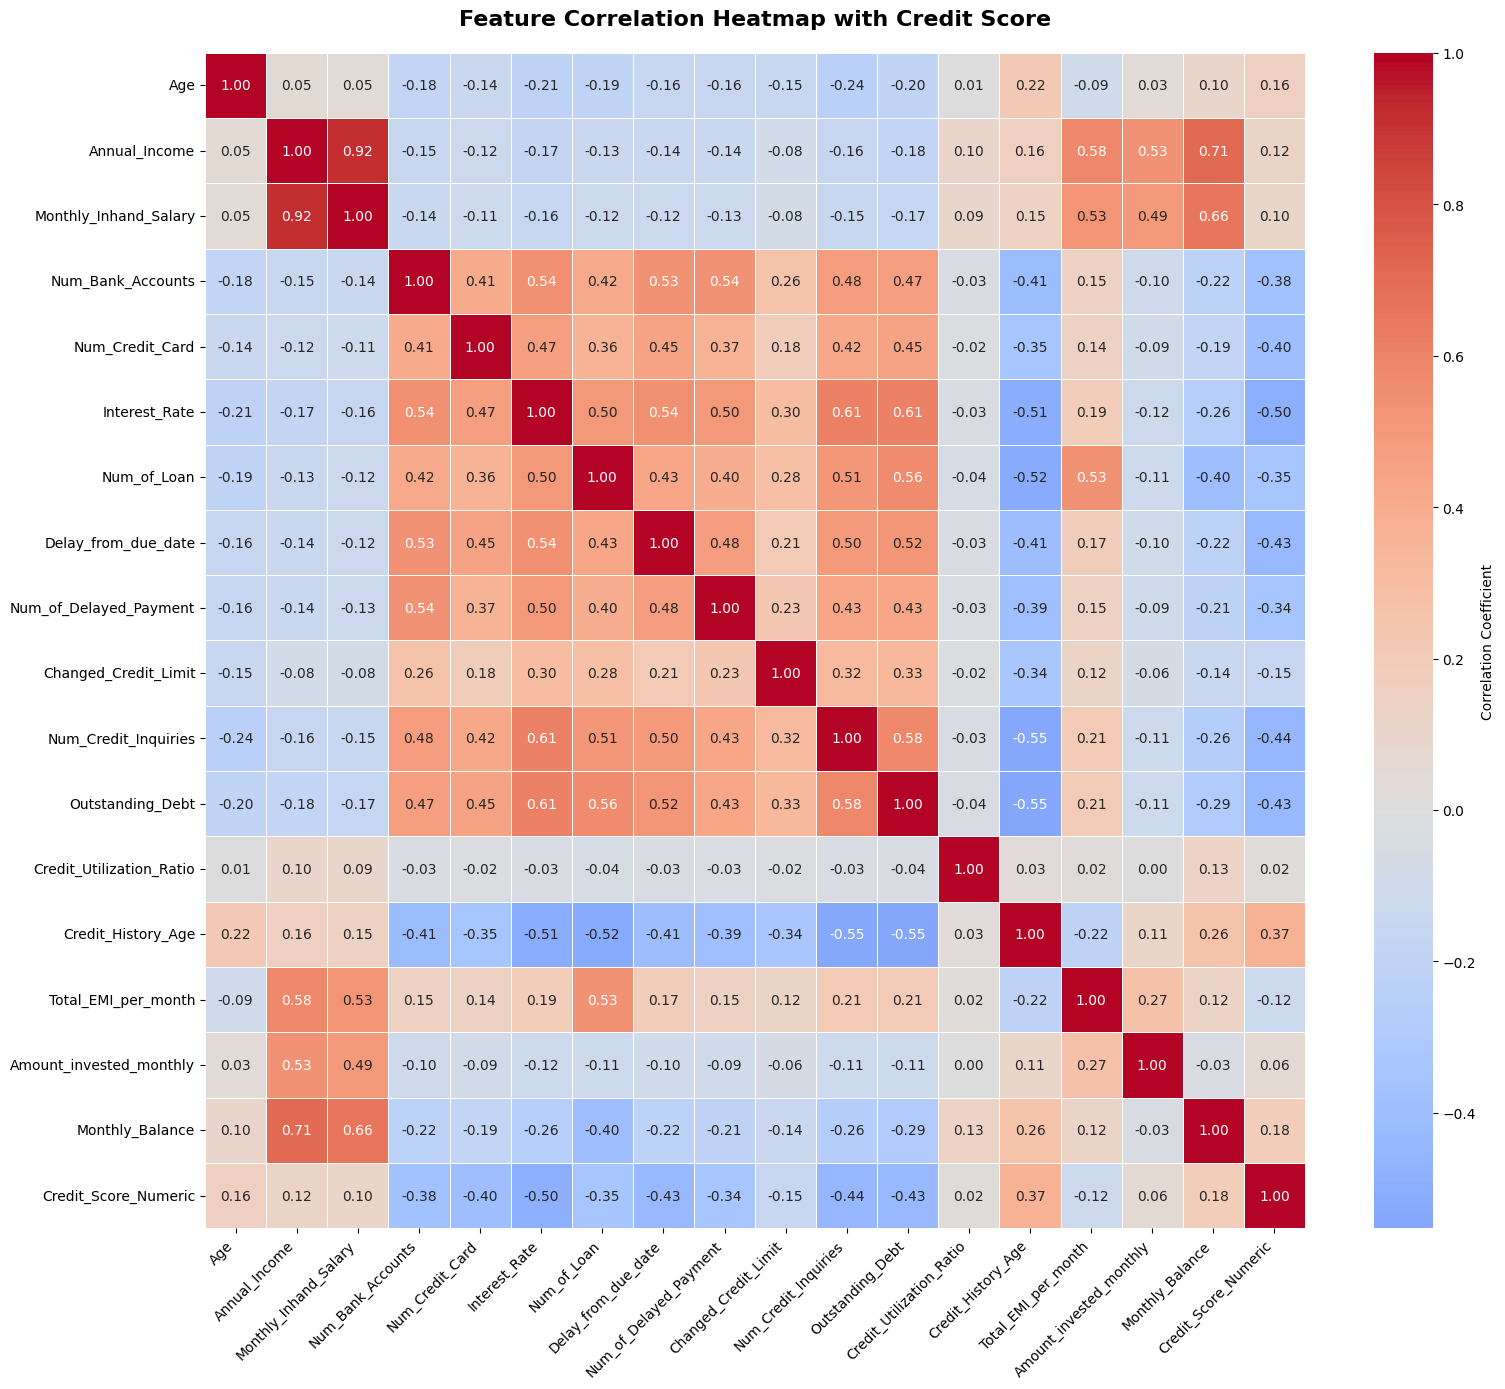

=== Top Features Correlated with Credit Score ===
Credit_History_Age          0.370893
Monthly_Balance             0.183823
Age                         0.160074
Annual_Income               0.115972
Monthly_Inhand_Salary       0.104666
Amount_invested_monthly     0.060079
Credit_Utilization_Ratio    0.022570
Total_EMI_per_month        -0.122962
Changed_Credit_Limit       -0.154554
Num_of_Delayed_Payment     -0.342033
Num_of_Loan                -0.346308
Num_Bank_Accounts          -0.378862
Num_Credit_Card            -0.400285
Delay_from_due_date        -0.427823
Outstanding_Debt           -0.428624
Num_Credit_Inquiries       -0.444357
Interest_Rate              -0.501192
Name: Credit_Score_Numeric, dtype: float64

💡 Insight: Features with |correlation| > 0.3 have strong influence on credit score


In [23]:
# Select key numeric features for correlation analysis
numeric_features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 
                    'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                    'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

# Create a correlation matrix with target (using original numeric target before encoding)
df_corr = df_ready_for_encoding[numeric_features].copy()
# Use numeric mapping for correlation analysis
credit_score_numeric = df_ready_for_encoding['Credit_Score'].map({'Poor': 0, 'Standard': 1, 'Good': 2})
df_corr['Credit_Score_Numeric'] = credit_score_numeric

correlation_matrix = df_corr.corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Heatmap with Credit Score', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display top correlations with Credit Score
credit_score_corr = correlation_matrix['Credit_Score_Numeric'].sort_values(ascending=False)
print("=== Top Features Correlated with Credit Score ===")
print(credit_score_corr.drop('Credit_Score_Numeric'))
print("\n💡 Insight: Features with |correlation| > 0.3 have strong influence on credit score")

C:\Users\Vespula\AppData\Local\Temp\ipykernel_22376\1475966692.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ready_for_encoding, x='Credit_Score', y='Annual_Income',
C:\Users\Vespula\AppData\Local\Temp\ipykernel_22376\1475966692.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ready_for_encoding, x='Credit_Score', y='Outstanding_Debt',
C:\Users\Vespula\AppData\Local\Temp\ipykernel_22376\1475966692.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ready_for_encoding, x='Credit_Score', y='Credit_Utilization

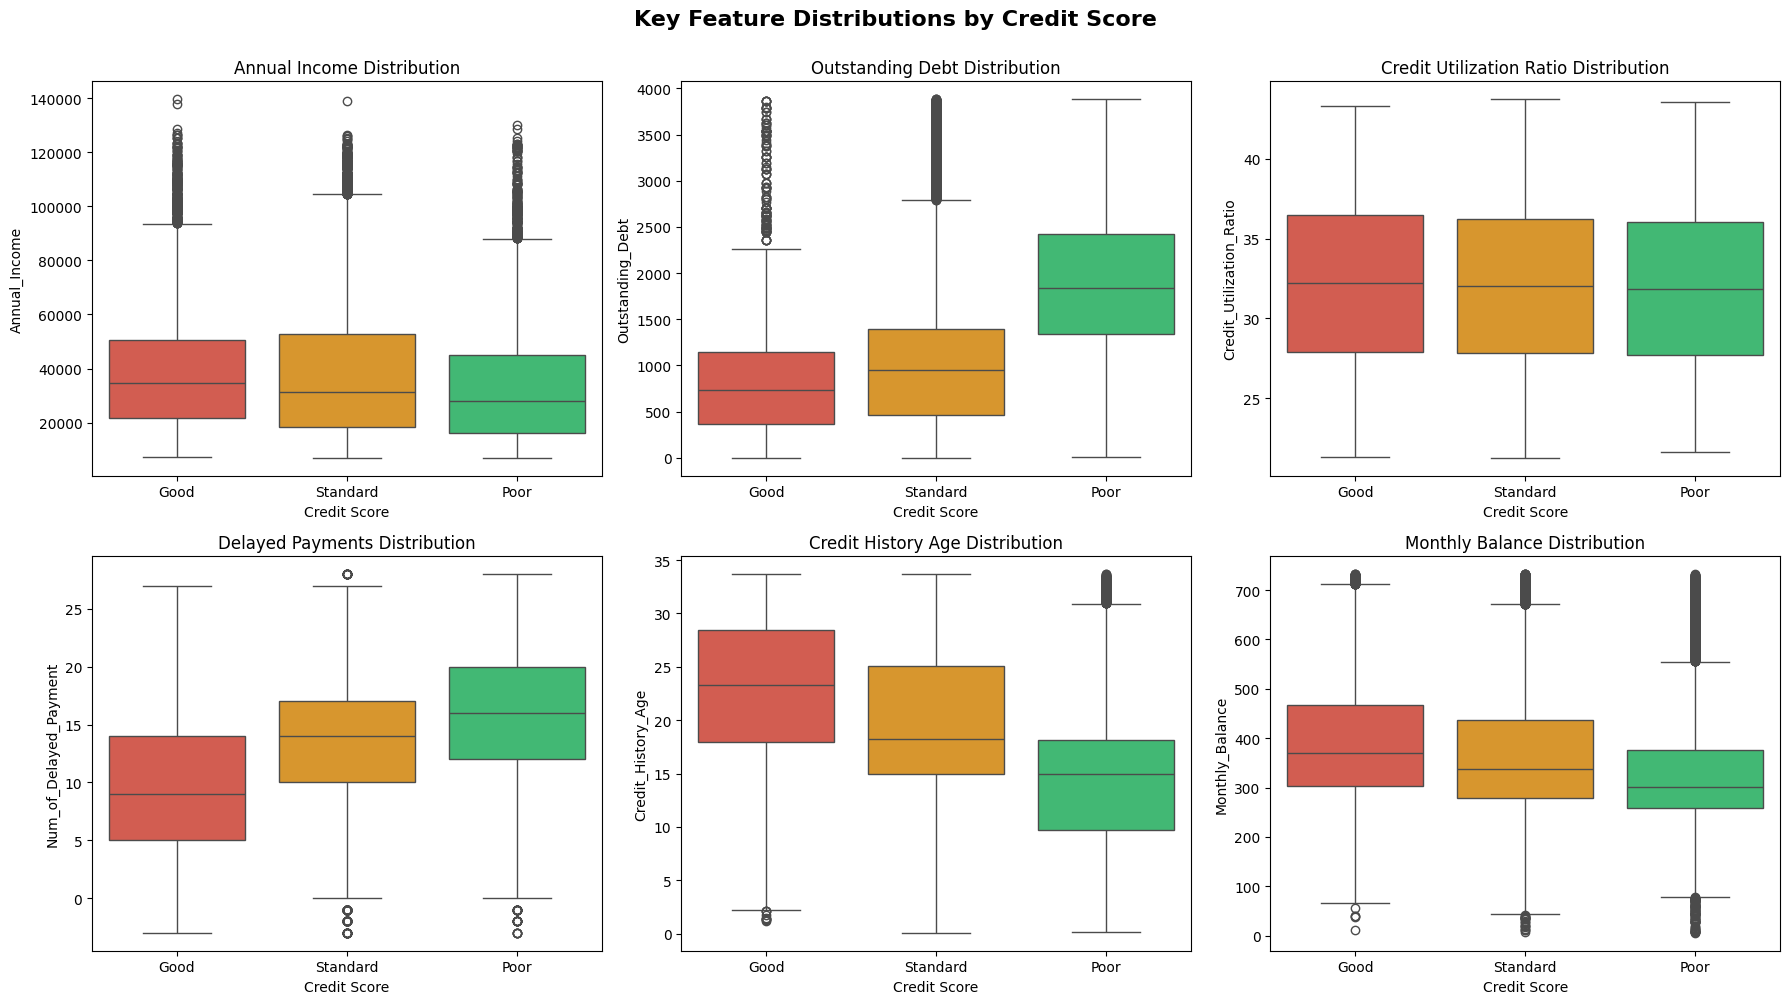

💡 Insights from distributions:
- Good credit scores tend to have higher income and longer credit history
- Poor credit scores show higher outstanding debt and delayed payments
- Credit utilization ratio increases as credit score decreases


In [24]:
# Distribution plots for key features by Credit Score
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Key Feature Distributions by Credit Score', fontsize=16, fontweight='bold', y=1.00)

# Annual Income
sns.boxplot(data=df_ready_for_encoding, x='Credit_Score', y='Annual_Income', 
            palette=['#e74c3c', '#f39c12', '#2ecc71'], ax=axes[0, 0])
axes[0, 0].set_title('Annual Income Distribution')
axes[0, 0].set_xlabel('Credit Score')

# Outstanding Debt
sns.boxplot(data=df_ready_for_encoding, x='Credit_Score', y='Outstanding_Debt', 
            palette=['#e74c3c', '#f39c12', '#2ecc71'], ax=axes[0, 1])
axes[0, 1].set_title('Outstanding Debt Distribution')
axes[0, 1].set_xlabel('Credit Score')

# Credit Utilization Ratio
sns.boxplot(data=df_ready_for_encoding, x='Credit_Score', y='Credit_Utilization_Ratio', 
            palette=['#e74c3c', '#f39c12', '#2ecc71'], ax=axes[0, 2])
axes[0, 2].set_title('Credit Utilization Ratio Distribution')
axes[0, 2].set_xlabel('Credit Score')

# Number of Delayed Payments
sns.boxplot(data=df_ready_for_encoding, x='Credit_Score', y='Num_of_Delayed_Payment', 
            palette=['#e74c3c', '#f39c12', '#2ecc71'], ax=axes[1, 0])
axes[1, 0].set_title('Delayed Payments Distribution')
axes[1, 0].set_xlabel('Credit Score')

# Credit History Age
sns.boxplot(data=df_ready_for_encoding, x='Credit_Score', y='Credit_History_Age', 
            palette=['#e74c3c', '#f39c12', '#2ecc71'], ax=axes[1, 1])
axes[1, 1].set_title('Credit History Age Distribution')
axes[1, 1].set_xlabel('Credit Score')

# Monthly Balance
sns.boxplot(data=df_ready_for_encoding, x='Credit_Score', y='Monthly_Balance', 
            palette=['#e74c3c', '#f39c12', '#2ecc71'], ax=axes[1, 2])
axes[1, 2].set_title('Monthly Balance Distribution')
axes[1, 2].set_xlabel('Credit Score')

plt.tight_layout()
plt.show()

print("💡 Insights from distributions:")
print("- Good credit scores tend to have higher income and longer credit history")
print("- Poor credit scores show higher outstanding debt and delayed payments")
print("- Credit utilization ratio increases as credit score decreases")

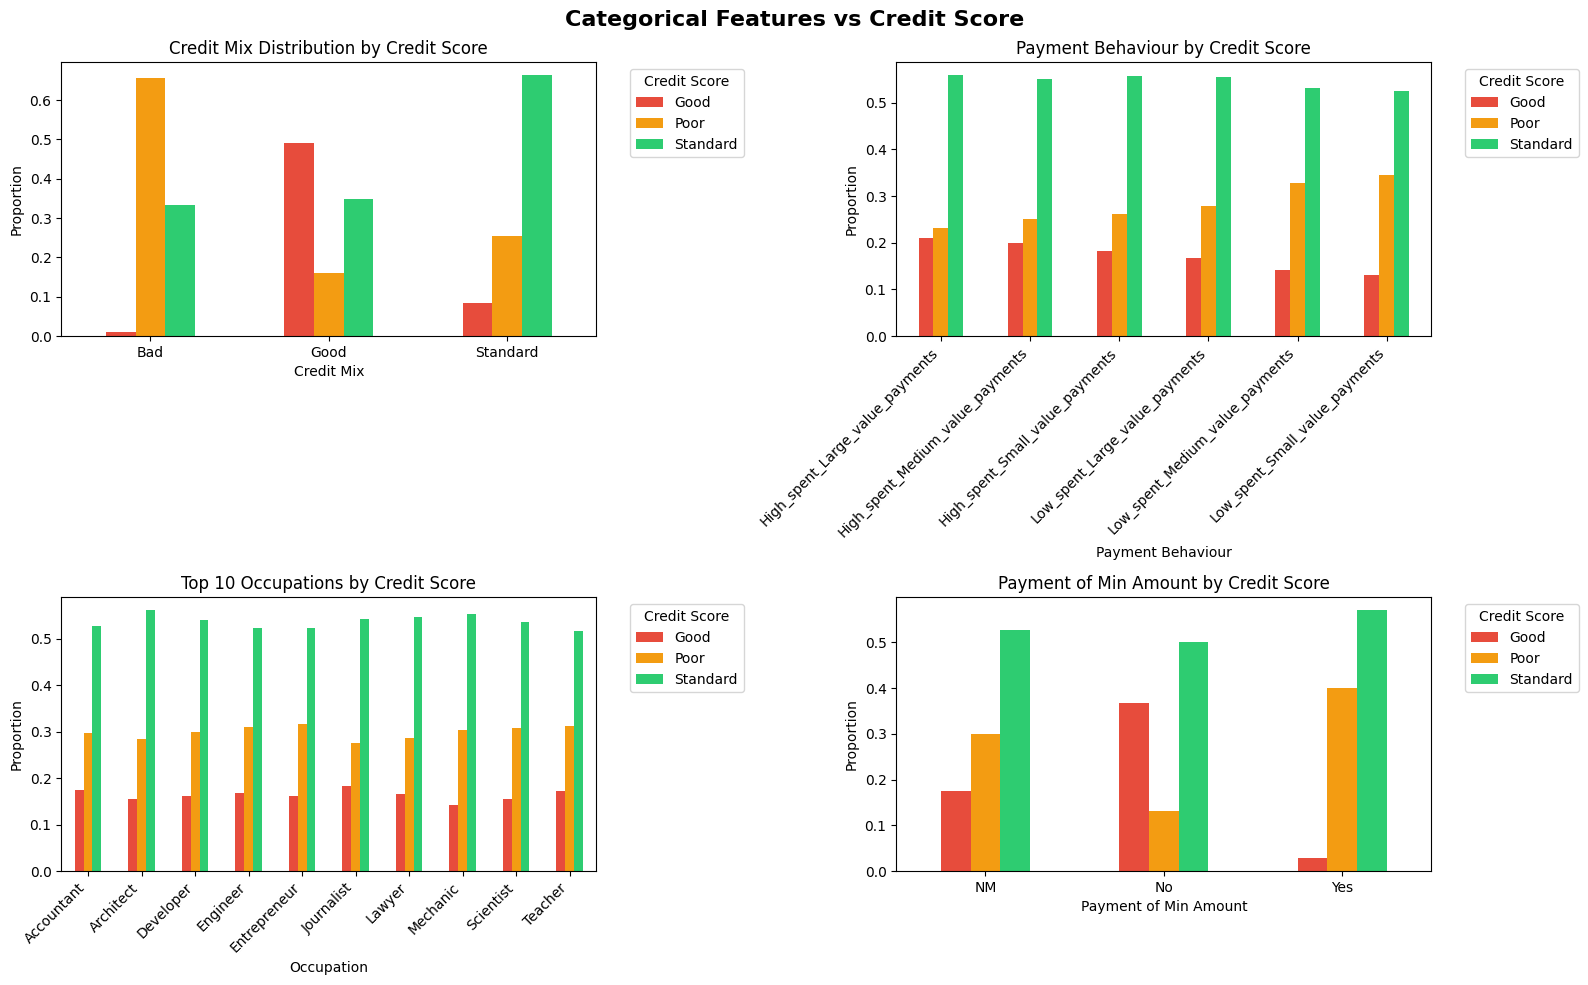

💡 Key categorical insights:
- Credit Mix quality strongly correlates with credit score
- Payment behaviour patterns are strong predictors
- Payment of minimum amount shows clear differentiation between classes


In [25]:
# Categorical features relationship with Credit Score
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Categorical Features vs Credit Score', fontsize=16, fontweight='bold')

# Credit Mix
pd.crosstab(df_ready_for_encoding['Credit_Mix'], df_ready_for_encoding['Credit_Score'], normalize='index').plot(
    kind='bar', stacked=False, ax=axes[0, 0], color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[0, 0].set_title('Credit Mix Distribution by Credit Score')
axes[0, 0].set_xlabel('Credit Mix')
axes[0, 0].set_ylabel('Proportion')
axes[0, 0].legend(title='Credit Score', bbox_to_anchor=(1.05, 1))
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)

# Payment Behaviour
payment_behavior_counts = pd.crosstab(df_ready_for_encoding['Payment_Behaviour'], 
                                       df_ready_for_encoding['Credit_Score'], normalize='index')
payment_behavior_counts.plot(kind='bar', stacked=False, ax=axes[0, 1], color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[0, 1].set_title('Payment Behaviour by Credit Score')
axes[0, 1].set_xlabel('Payment Behaviour')
axes[0, 1].set_ylabel('Proportion')
axes[0, 1].legend(title='Credit Score', bbox_to_anchor=(1.05, 1))
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

# Occupation (top 10)
top_occupations = df_ready_for_encoding['Occupation'].value_counts().head(10).index
df_top_occ = df_ready_for_encoding[df_ready_for_encoding['Occupation'].isin(top_occupations)]
occupation_counts = pd.crosstab(df_top_occ['Occupation'], df_top_occ['Credit_Score'], normalize='index')
occupation_counts.plot(kind='bar', stacked=False, ax=axes[1, 0], color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[1, 0].set_title('Top 10 Occupations by Credit Score')
axes[1, 0].set_xlabel('Occupation')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].legend(title='Credit Score', bbox_to_anchor=(1.05, 1))
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# Payment of Minimum Amount
pd.crosstab(df_ready_for_encoding['Payment_of_Min_Amount'], 
            df_ready_for_encoding['Credit_Score'], normalize='index').plot(
    kind='bar', stacked=False, ax=axes[1, 1], color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[1, 1].set_title('Payment of Min Amount by Credit Score')
axes[1, 1].set_xlabel('Payment of Min Amount')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].legend(title='Credit Score', bbox_to_anchor=(1.05, 1))
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("💡 Key categorical insights:")
print("- Credit Mix quality strongly correlates with credit score")
print("- Payment behaviour patterns are strong predictors")
print("- Payment of minimum amount shows clear differentiation between classes")

## Convert Object Types to Categorical

In [26]:
# Convert all object columns to categorical dtype
for col in df_ready_for_encoding.select_dtypes(include='object').columns:
    df_ready_for_encoding[col] = df_ready_for_encoding[col].astype('category')

## Ordinal Categorical Encoding

Variables with inherent order: `Credit_Mix` (Bad < Standard < Good) and target `Credit_Score` (Poor < Standard < Good).

In [27]:
# Check unique values before encoding
print("Credit_Mix unique values:", df_ready_for_encoding['Credit_Mix'].unique())
print("Credit_Score unique values:", df_ready_for_encoding['Credit_Score'].unique())

Credit_Mix unique values: ['Standard', 'Good', 'Bad']
Categories (3, object): ['Bad', 'Good', 'Standard']
Credit_Score unique values: ['Good', 'Standard', 'Poor']
Categories (3, object): ['Good', 'Poor', 'Standard']


In [28]:
# Ordinal encoding for Credit_Mix and Credit_Score
credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2}
df_ready_for_encoding['Credit_Mix'] = df_ready_for_encoding['Credit_Mix'].map(credit_mix_map)

credit_score_map = {'Poor': 0, 'Standard': 1, 'Good': 2}
df_ready_for_encoding['Credit_Score'] = df_ready_for_encoding['Credit_Score'].map(credit_score_map)

print("Credit_Mix after encoding:", df_ready_for_encoding['Credit_Mix'].unique())
print("Credit_Score after encoding:", df_ready_for_encoding['Credit_Score'].unique())

Credit_Mix after encoding: [1, 2, 0]
Categories (3, int64): [0, 2, 1]
Credit_Score after encoding: [2, 1, 0]
Categories (3, int64): [2, 0, 1]


In [29]:
# Reset index after filtering operations
df_ready_for_encoding = df_ready_for_encoding.reset_index(drop=True)

## Nominal Categorical Encoding (One-Hot)

In [30]:
# One-hot encode nominal categorical variables.
# Why: Converts categories to binary indicators; drop_first avoids multicollinearity (dummy trap)
# and keeps feature space compact for tree splits and distance scaling.
nominal_vars = df_ready_for_encoding.select_dtypes(include='category').columns.difference(['Credit_Mix', 'Credit_Score'])
print("Nominal variables:", list(nominal_vars))

df_encoded = pd.get_dummies(df_ready_for_encoding, columns=nominal_vars, drop_first=True)
print(f"\nDataFrame shape after encoding: {df_encoded.shape}")

Nominal variables: ['Month', 'Occupation', 'Payment_Behaviour', 'Payment_of_Min_Amount', 'Type_of_Loan']

DataFrame shape after encoding: (56312, 122)


## Remove Month Variable

**Rationale:** The `Month` variable shows uniform distribution across all months, indicating no seasonality or temporal patterns relevant for credit score classification. 

Removing it eliminates noise and unnecessary dimensionality without losing predictive information.

In [31]:
# Drop Month variable (if it exists after encoding)
df_final = df_encoded.drop('Month', axis=1, errors='ignore')
print(f"Final DataFrame shape: {df_final.shape}")

Final DataFrame shape: (56312, 122)


## Clean Negative Values in Numeric Variables

### Identify Variables Where Negative Values Don't Make Sense

Based on business logic and data dictionary definitions.

### Variables Where Negatives ARE Valid:

- **Changed_Credit_Limit:** Represents change in limit; negative = reduction.
- **Delay_from_due_date:** Could be negative if payment made before due date.

In [32]:
# Review all numeric columns with negative values
print("Columns with negative values:\n")
for col in df_final.select_dtypes(include=[float, int]).columns:
    negatives = df_final[df_final[col] < 0][col]
    if len(negatives) > 0:
        print(f"Column: {col}")
        print(f"  Count of negatives: {len(negatives)}")
        print(f"  Example negative values: {negatives.unique()[:10]}")
        print("-" * 40)

Columns with negative values:

Column: Num_Bank_Accounts
  Count of negatives: 5
  Example negative values: [-1]
----------------------------------------
Column: Delay_from_due_date
  Count of negatives: 299
  Example negative values: [-1 -2 -3 -5 -4]
----------------------------------------
Column: Num_of_Delayed_Payment
  Count of negatives: 337
  Example negative values: [-1. -2. -3.]
----------------------------------------
Column: Changed_Credit_Limit
  Count of negatives: 872
  Example negative values: [-2.01 -3.01 -1.24 -2.87 -4.26 -1.26 -1.33 -1.48 -2.17 -1.1 ]
----------------------------------------


In [33]:
# List of columns where negative values should NOT exist
cols_no_negatives = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
    'Num_Credit_Cards', 'Interest_Rate', 'Num_of_Loan', 'Num_of_Delayed_Payment',
    'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
    'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly'
]

print("Checking columns that should not have negatives:\n")
for col in cols_no_negatives:
    if col in df_final.columns:
        negatives = df_final[df_final[col] < 0][col]
        if len(negatives) > 0:
            print(f"Column: {col}")
            print(f"  Count of negatives: {len(negatives)}")
            print(f"  Example negative values: {negatives.unique()[:10]}")
            print("-" * 40)

Checking columns that should not have negatives:

Column: Num_Bank_Accounts
  Count of negatives: 5
  Example negative values: [-1]
----------------------------------------
Column: Num_of_Delayed_Payment
  Count of negatives: 337
  Example negative values: [-1. -2. -3.]
----------------------------------------
Column: Num_Bank_Accounts
  Count of negatives: 5
  Example negative values: [-1]
----------------------------------------
Column: Num_of_Delayed_Payment
  Count of negatives: 337
  Example negative values: [-1. -2. -3.]
----------------------------------------


In [34]:
# Replace negative values with NaN in columns where they shouldn't exist
for col in cols_no_negatives:
    if col in df_final.columns:
        df_final.loc[df_final[col] < 0, col] = np.nan

# Impute NaN values with median
for col in cols_no_negatives:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(df_final[col].median())

print("Negative values replaced and imputed with median.")

Negative values replaced and imputed with median.


In [35]:
# Verify index integrity and check for missing values
print("Index minimum:", df_final.index.min())
print("Index maximum:", df_final.index.max())
print("Number of rows:", len(df_final))
print("Duplicate indices?:", df_final.index.duplicated().any())
print("Missing values in DataFrame?:", df_final.isnull().sum().sum() > 0)

Index minimum: 0
Index maximum: 56311
Number of rows: 56312
Duplicate indices?: False
Missing values in DataFrame?: False


## Split Features and Target Variable

In [36]:
# Separate features (X) and target (y)
X = df_final.drop('Credit_Score', axis=1)
y = df_final['Credit_Score']

# Split into training and test sets with stratification
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print("Training and test sets created:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape: {y_test.shape}")

Training and test sets created:
  X_train shape: (45049, 121)
  X_test shape: (11263, 121)
  y_train shape: (45049,)
  y_test shape: (11263,)


## Standardize Features

Apply StandardScaler to normalize features for distance-based models (KNN) while preserving tree-based model performance.

In [37]:
# Standardize continuous features.
# Why: KNN and other distance-based models rely on scale parity; trees are scale-invariant
# but keeping a scaled copy (X_train_scaled) enables fair model comparison without leakage.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit only on training set
X_test_scaled = scaler.transform(X_test)

print("Feature standardization complete.")

Feature standardization complete.


## Model Selection and Hyperparameter Tuning

Using GridSearchCV to find optimal hyperparameters for Decision Tree, Random Forest, and KNN classifiers.

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Hyperparameter rationale:
# - max_depth (trees): controls overfitting; None lets tree grow fully if justified.
# - min_samples_split: regularizes small noisy splits.
# - n_estimators (RF): more trees reduce variance but increase cost; grid balances performance vs time.
# - KNN n_neighbors: bias-variance trade-off; weights='distance' (in separate grid) could mitigate class imbalance.

param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)
print("Best Decision Tree:", grid_dt.best_params_)
print("Cross-validation accuracy:", grid_dt.best_score_)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print("\nBest Random Forest:", grid_rf.best_params_)
print("Cross-validation accuracy:", grid_rf.best_score_)

param_grid_knn = {
    'n_neighbors': [3, 5, 9, 15]
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled, y_train)
print("\nBest KNN:", grid_knn.best_params_)
print("Cross-validation accuracy:", grid_knn.best_score_)

Best Decision Tree: {'max_depth': 10, 'min_samples_split': 5}
Cross-validation accuracy: 0.7305601267643443

Best Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation accuracy: 0.7828588060108593

Best Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation accuracy: 0.7828588060108593

Best KNN: {'n_neighbors': 15}
Cross-validation accuracy: 0.6585940585496635

Best KNN: {'n_neighbors': 15}
Cross-validation accuracy: 0.6585940585496635


### Feature Importance Analysis
Understanding which features drive model predictions helps validate business logic and supports explainability for stakeholders.

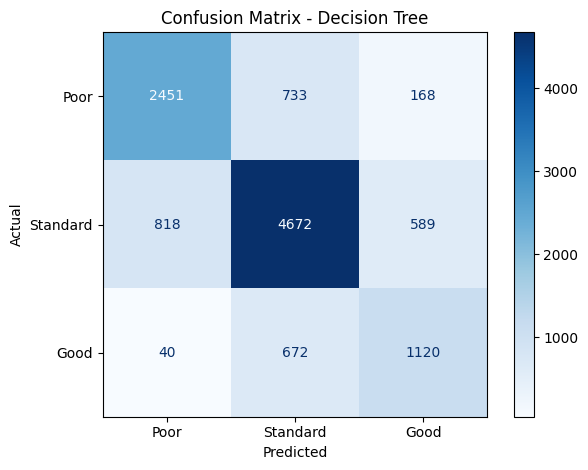

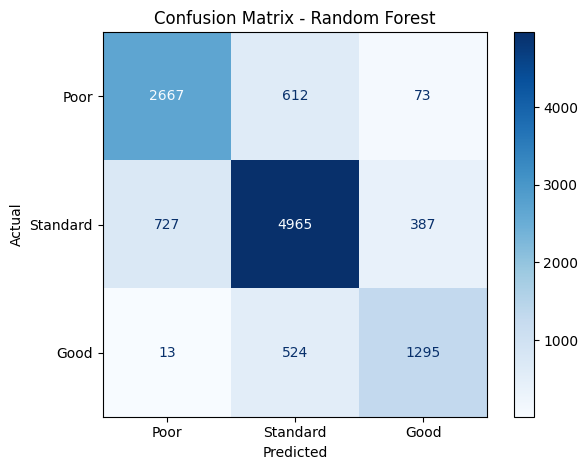

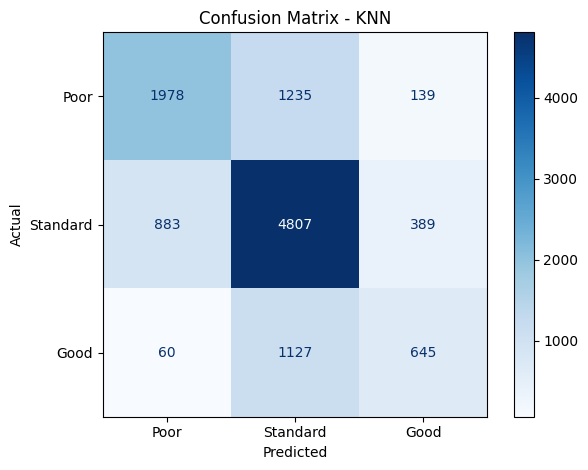


Processed dataset saved to: ../data/processed/set_credit_score_ramior_ottone_villar.csv


In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

score_codes = [0, 1, 2]
score_labels = ['Poor', 'Standard', 'Good']

# Best estimators from GridSearchCV
best_dt = grid_dt.best_estimator_
best_rf = grid_rf.best_estimator_
best_knn = grid_knn.best_estimator_

y_pred_dt = best_dt.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_knn = best_knn.predict(X_test_scaled)

# Helper to avoid repeating plotting boilerplate
def plot_confusion(ax_title: str, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=score_codes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=score_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(ax_title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

plot_confusion("Confusion Matrix - Decision Tree", y_test, y_pred_dt)
plot_confusion("Confusion Matrix - Random Forest", y_test, y_pred_rf)
plot_confusion("Confusion Matrix - KNN", y_test, y_pred_knn)

# Save processed dataset with relative path
df_final.to_csv('../data/processed/set_credit_score_ramior_ottone_villar.csv', index=False)
print("\nProcessed dataset saved to: ../data/processed/set_credit_score_ramior_ottone_villar.csv")

## Conclusions and Model Selection

### Problem Summary
To address the credit score classification problem, three models were tested: Decision Tree, Random Forest, and KNN, using cross-validation and hyperparameter search to maximize accuracy.

The process included:
- Data cleaning and handling missing values
- Outlier treatment using IQR method
- Categorical variable transformation (ordinal + one-hot encoding)
- Feature standardization for distance-based models

### Model Comparison Results

After comparing precision, recall, and F1-score on the test set, **Random Forest** emerged as the best model with optimal hyperparameters:

- **n_estimators:** 100
- **max_depth:** 10
- **min_samples_split:** 2

### Why Random Forest?

1. **Highest accuracy** and balanced metrics in both cross-validation and test set
2. **Robust to outliers** and irrelevant variables
3. **Reduces overfitting risk** compared to single decision tree by combining multiple trees and averaging their predictions
4. **Better generalization:** These hyperparameters balance model complexity, avoiding both overfitting (too complex) and underfitting (too simple)

### Recommendation

The Random Forest model with these parameters is the most suitable for predicting credit scores on future observations in this dataset.

In [40]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import numpy as np

def bootstrap_grid_search(model_class, param_grid, X_train, y_train, X_test, y_test, n_iterations=30):
    """
    Perform hyperparameter search using bootstrap resampling for stability assessment.
    
    Args:
        model_class: Classifier class (e.g., RandomForestClassifier)
        param_grid: Dictionary of hyperparameters to test
        X_train, y_train: Training data
        X_test, y_test: Test data
        n_iterations: Number of bootstrap iterations
    
    Returns:
        best_params, best_score, all_scores
    """
    from itertools import product
    best_score = -np.inf
    best_params = None
    all_scores = []
    keys, values = zip(*param_grid.items())
    
    for v in product(*values):
        params = dict(zip(keys, v))
        scores = []
        for i in range(n_iterations):
            X_res, y_res = resample(X_train, y_train, replace=True, random_state=RANDOM_STATE+i)
            # Add random_state only if model supports it
            if 'random_state' in model_class().get_params():
                model = model_class(**params, random_state=RANDOM_STATE)
            else:
                model = model_class(**params)
            model.fit(X_res, y_res)
            y_pred = model.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        mean_score = np.mean(scores)
        all_scores.append((params, mean_score))
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
        print(f"Parameters: {params}, Bootstrap avg accuracy: {mean_score:.4f}")
    
    print(f"\nBest parameters: {best_params}, Best accuracy: {best_score:.4f}")
    return best_params, best_score, all_scores

# Bootstrap search for Random Forest
print("="*60)
print("BOOTSTRAP HYPERPARAMETER SEARCH - RANDOM FOREST")
print("="*60)
param_grid_rf_bootstrap = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}
best_params_rf, best_score_rf, all_scores_rf = bootstrap_grid_search(
    RandomForestClassifier, param_grid_rf_bootstrap, X_train, y_train, X_test, y_test
)

# Bootstrap search for Decision Tree
print("\n" + "="*60)
print("BOOTSTRAP HYPERPARAMETER SEARCH - DECISION TREE")
print("="*60)
param_grid_dt_bootstrap = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5]
}
best_params_dt, best_score_dt, all_scores_dt = bootstrap_grid_search(
    DecisionTreeClassifier, param_grid_dt_bootstrap, X_train, y_train, X_test, y_test
)

# Bootstrap search for KNN (uses scaled data)
print("\n" + "="*60)
print("BOOTSTRAP HYPERPARAMETER SEARCH - KNN")
print("="*60)
param_grid_knn_bootstrap = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
best_params_knn, best_score_knn, all_scores_knn = bootstrap_grid_search(
    KNeighborsClassifier, param_grid_knn_bootstrap, X_train_scaled, y_train, X_test_scaled, y_test
)

BOOTSTRAP HYPERPARAMETER SEARCH - RANDOM FOREST
Parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2}, Bootstrap avg accuracy: 0.6696
Parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2}, Bootstrap avg accuracy: 0.6696
Parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5}, Bootstrap avg accuracy: 0.6700
Parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5}, Bootstrap avg accuracy: 0.6700
Parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}, Bootstrap avg accuracy: 0.7144
Parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}, Bootstrap avg accuracy: 0.7144
Parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}, Bootstrap avg accuracy: 0.7139
Parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}, Bootstrap avg accuracy: 0.7139
Parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2}, Bootstrap avg accuracy: 0.6710
Pa

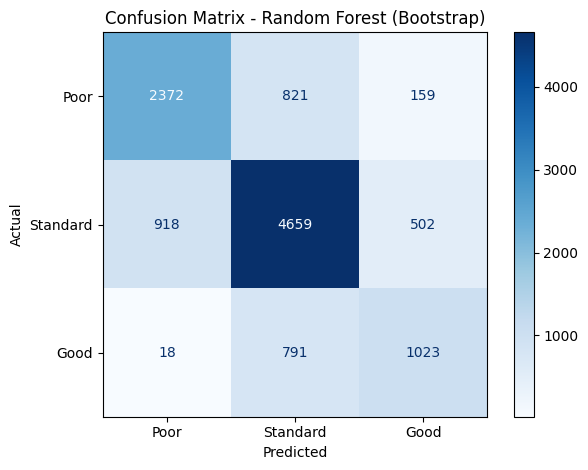

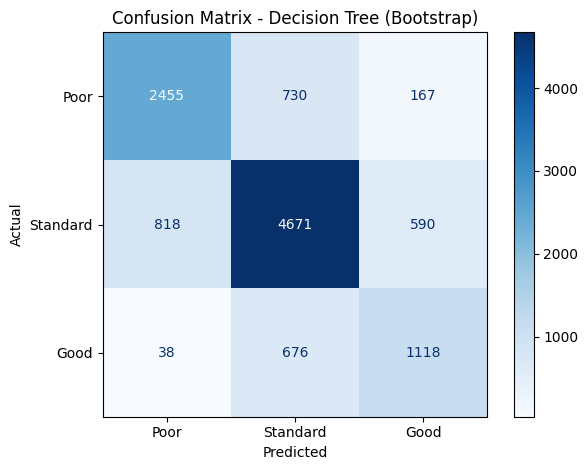

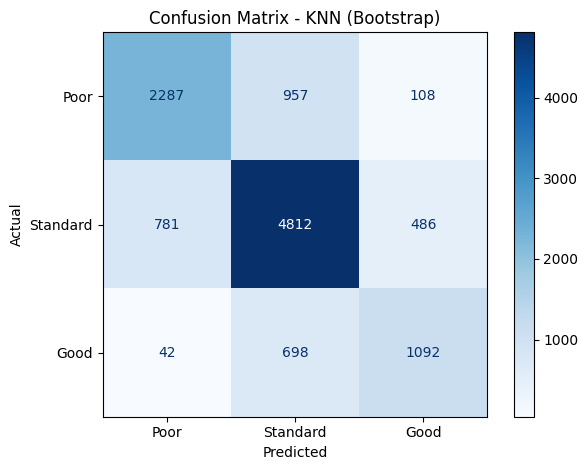

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Random Forest with best bootstrap parameters
rf_bootstrap = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=RANDOM_STATE
)
rf_bootstrap.fit(X_train, y_train)
y_pred_rf_bootstrap = rf_bootstrap.predict(X_test)

cm_rf_bootstrap = confusion_matrix(y_test, y_pred_rf_bootstrap)
disp_rf_bootstrap = ConfusionMatrixDisplay(confusion_matrix=cm_rf_bootstrap, 
                                          display_labels=['Poor', 'Standard', 'Good'])
disp_rf_bootstrap.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest (Bootstrap)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Decision Tree with best bootstrap parameters
dt_bootstrap = DecisionTreeClassifier(
    max_depth=best_params_dt['max_depth'],
    min_samples_split=best_params_dt['min_samples_split'],
    random_state=RANDOM_STATE
)
dt_bootstrap.fit(X_train, y_train)
y_pred_dt_bootstrap = dt_bootstrap.predict(X_test)

cm_dt_bootstrap = confusion_matrix(y_test, y_pred_dt_bootstrap)
disp_dt_bootstrap = ConfusionMatrixDisplay(confusion_matrix=cm_dt_bootstrap,
                                          display_labels=['Poor', 'Standard', 'Good'])
disp_dt_bootstrap.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree (Bootstrap)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# KNN with best bootstrap parameters (uses scaled data)
knn_bootstrap = KNeighborsClassifier(
    n_neighbors=best_params_knn['n_neighbors'],
    weights=best_params_knn['weights'],
    p=best_params_knn['p']
)
knn_bootstrap.fit(X_train_scaled, y_train)
y_pred_knn_bootstrap = knn_bootstrap.predict(X_test_scaled)

cm_knn_bootstrap = confusion_matrix(y_test, y_pred_knn_bootstrap)
disp_knn_bootstrap = ConfusionMatrixDisplay(confusion_matrix=cm_knn_bootstrap,
                                           display_labels=['Poor', 'Standard', 'Good'])
disp_knn_bootstrap.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN (Bootstrap)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

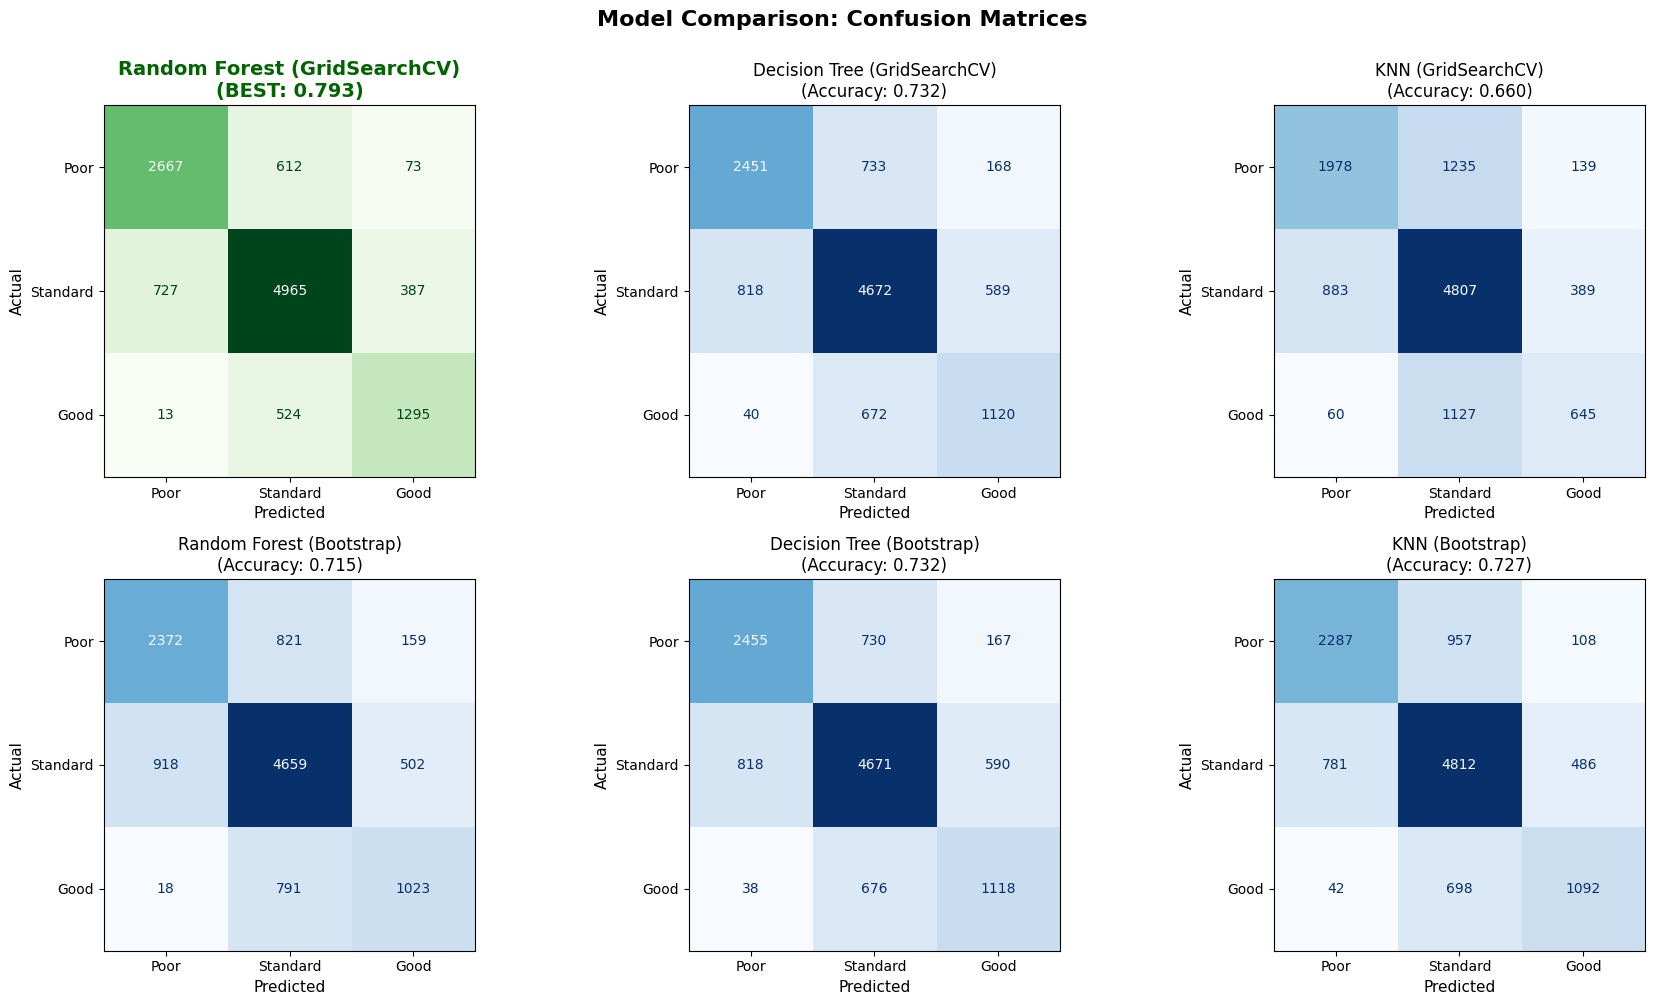


MODEL PERFORMANCE SUMMARY
Random Forest (GridSearchCV)             Accuracy: 0.7926 ← BEST
Decision Tree (GridSearchCV)             Accuracy: 0.7319
KNN (GridSearchCV)                       Accuracy: 0.6597
Random Forest (Bootstrap)                Accuracy: 0.7151
Decision Tree (Bootstrap)                Accuracy: 0.7320
KNN (Bootstrap)                          Accuracy: 0.7272


In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy for all models
accuracies = [
    accuracy_score(y_test, y_pred_rf),           # 0: RF GridSearchCV
    accuracy_score(y_test, y_pred_dt),           # 1: DT GridSearchCV
    accuracy_score(y_test, y_pred_knn),          # 2: KNN GridSearchCV
    accuracy_score(y_test, y_pred_rf_bootstrap), # 3: RF Bootstrap
    accuracy_score(y_test, y_pred_dt_bootstrap), # 4: DT Bootstrap
    accuracy_score(y_test, y_pred_knn_bootstrap) # 5: KNN Bootstrap
]

model_names = [
    "Random Forest (GridSearchCV)",
    "Decision Tree (GridSearchCV)",
    "KNN (GridSearchCV)",
    "Random Forest (Bootstrap)",
    "Decision Tree (Bootstrap)",
    "KNN (Bootstrap)"
]

predictions = [
    y_pred_rf, y_pred_dt, y_pred_knn,
    y_pred_rf_bootstrap, y_pred_dt_bootstrap, y_pred_knn_bootstrap
]

# Find best model
best_idx = accuracies.index(max(accuracies))

# Create comparison grid: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (ax, name, y_pred, acc) in enumerate(zip(axes, model_names, predictions, accuracies)):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Poor', 'Standard', 'Good'])
    
    if i == best_idx:
        # Highlight best model
        disp.plot(ax=ax, cmap=plt.cm.Greens, colorbar=False)
        ax.set_title(f"{name}\n(BEST: {acc:.3f})", fontsize=14, fontweight='bold', color='darkgreen')
    else:
        disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
        ax.set_title(f"{name}\n(Accuracy: {acc:.3f})", fontsize=12)
    
    ax.set_xlabel("Predicted", fontsize=11)
    ax.set_ylabel("Actual", fontsize=11)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)

plt.suptitle("Model Comparison: Confusion Matrices", fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
for name, acc in zip(model_names, accuracies):
    marker = " ← BEST" if acc == max(accuracies) else ""
    print(f"{name:40s} Accuracy: {acc:.4f}{marker}")

## Final Conclusion

### Selected Model

The chosen model for credit score classification is **Random Forest (GridSearchCV)** with the following hyperparameters:

- **n_estimators:** 100
- **max_depth:** 10
- **min_samples_split:** 2

This model achieves the best balance between accuracy and robustness, generalizes well to new data, and shows consistency across different validation methodologies (cross-validation and bootstrap).

### Business Context: Error Importance in Banking

In credit score evaluation for banking institutions, **minimizing false positives is critical** — specifically, avoiding classifying customers as "Standard" or "Good" when they actually have a "Poor" score. 

**Why?** Lending money to someone who shouldn't receive it represents a much greater financial risk for the institution than denying a loan to a creditworthy customer.

### Error Analysis

Analyzing the confusion matrix of the Random Forest (GridSearchCV) model, the sum of "Standard" and "Good" predictions when the actual class was "Poor" equals **685 cases**. These represent the false positives we most want to avoid.

Therefore, model selection is based not only on overall accuracy but also on the ability to minimize these critical errors for the bank's financial security.

### Summary

Random Forest with these hyperparameters is the most reliable option for predicting credit scores, prioritizing the reduction of false positives and, consequently, risk for the institution.

## Cross-Validation Stability Check

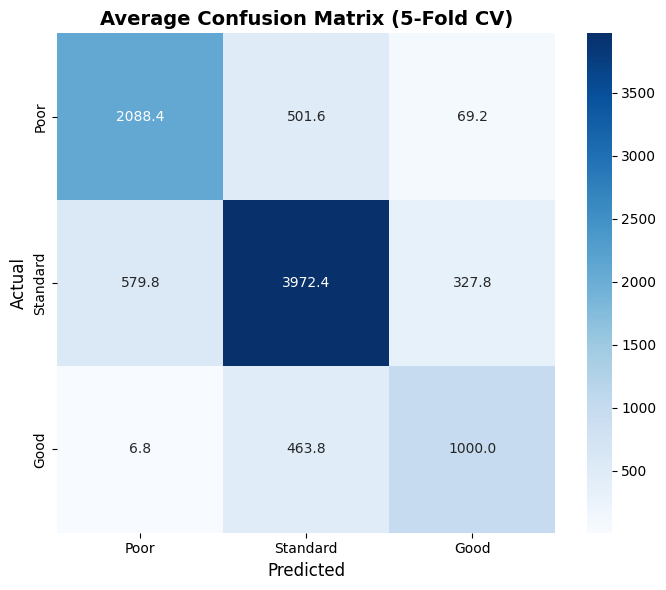

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import numpy as np

# Stratified K-Fold cross-validation for stability assessment
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
confusion_matrices = []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Scale features
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    # Train model with best parameters
    model = RandomForestClassifier(**grid_rf.best_params_, random_state=RANDOM_STATE)
    model.fit(X_tr_scaled, y_tr)
    y_pred = model.predict(X_val_scaled)
    
    # Store confusion matrix
    cm = confusion_matrix(y_val, y_pred, labels=[0, 1, 2])
    confusion_matrices.append(cm)

# Average confusion matrix across folds
cm_mean = np.mean(confusion_matrices, axis=0)

# Visualize average confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))
sns.heatmap(cm_mean, annot=True, fmt=".1f", cmap="Blues", 
            xticklabels=['Poor', 'Standard', 'Good'], 
            yticklabels=['Poor', 'Standard', 'Good'])
plt.title("Average Confusion Matrix (5-Fold CV)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

In [44]:
# Best model predictions on test set
y_pred_best = grid_rf.predict(X_test)

# DataFrame with actual and predicted results
df_errors = X_test.copy()
df_errors['Actual'] = y_test.values
df_errors['Predicted'] = y_pred_best

# False positives: predicted "Standard" or "Good" when actual was "Poor"
false_positives = df_errors[(df_errors['Actual'] == 0) & (df_errors['Predicted'] != 0)]

# False negatives: predicted "Poor" when actual was "Standard" or "Good"
false_negatives = df_errors[(df_errors['Actual'] != 0) & (df_errors['Predicted'] == 0)]

print("="*60)
print("ERROR ANALYSIS")
print("="*60)
print(f"False positives (High Risk for Bank): {len(false_positives)}")
print(f"False negatives (Missed Opportunities): {len(false_negatives)}")
print(f"\nTotal test samples: {len(df_errors)}")
print(f"Correct predictions: {len(df_errors) - len(false_positives) - len(false_negatives)}")
print(f"Overall accuracy: {(len(df_errors) - len(false_positives) - len(false_negatives)) / len(df_errors):.4f}")

# Analyze numeric feature means in errors
numeric_features = X_test.select_dtypes(include=[np.number]).columns

print("\n" + "="*60)
print("FEATURE ANALYSIS: FALSE POSITIVES vs CORRECT PREDICTIONS")
print("="*60)
correct_preds = df_errors[df_errors['Actual'] == df_errors['Predicted']]

for feature in numeric_features[:10]:  # Show top 10 numeric features
    if feature in df_errors.columns:
        fp_mean = false_positives[feature].mean()
        correct_mean = correct_preds[feature].mean()
        diff_pct = ((fp_mean - correct_mean) / correct_mean * 100) if correct_mean != 0 else 0
        print(f"{feature:30s} | FP: {fp_mean:8.2f} | Correct: {correct_mean:8.2f} | Diff: {diff_pct:+6.1f}%")

ERROR ANALYSIS
False positives (High Risk for Bank): 685
False negatives (Missed Opportunities): 740

Total test samples: 11263
Correct predictions: 9838
Overall accuracy: 0.8735

FEATURE ANALYSIS: FALSE POSITIVES vs CORRECT PREDICTIONS
Age                            | FP:    34.63 | Correct:    33.26 | Diff:   +4.1%
Annual_Income                  | FP: 37587.87 | Correct: 36453.56 | Diff:   +3.1%
Monthly_Inhand_Salary          | FP:  3113.00 | Correct:  3037.78 | Diff:   +2.5%
Num_Bank_Accounts              | FP:     4.68 | Correct:     5.43 | Diff:  -13.9%
Num_Credit_Card                | FP:     5.26 | Correct:     5.46 | Diff:   -3.6%
Interest_Rate                  | FP:    11.83 | Correct:    14.58 | Diff:  -18.9%
Num_of_Loan                    | FP:     2.95 | Correct:     3.43 | Diff:  -14.1%
Delay_from_due_date            | FP:    16.87 | Correct:    20.21 | Diff:  -16.5%
Num_of_Delayed_Payment         | FP:    12.15 | Correct:    13.61 | Diff:  -10.7%
Changed_Credit_Limit     